![](https://i.imgur.com/eBRPvWB.png)

# Generowanie sztuki za pomocą RNN i PyTorch w oparciu o litery.

[W tutorialu](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) użyliśmy RNN, aby sklasyfikować tekst po jednym znaku na raz. Tym razem wygenerujemy tekst po jednym znaku na raz.
```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

Zobacz [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) żeby nauczyć się więcej w tym temacie.

# Warto przeczytać

Zakładam, że zainstalowałeś przynajmniej PyTorch, znasz Pythona i rozumiesz Tensory:

* http://pytorch.org/ Instrukcje instalacji
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) na początek z PyTorch (ogólnie)
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) dla szczegółowego przeglądu
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) jeśli jesteś poprzednim użytkownikiem Lua Torch

Przydałoby się również wiedzieć o RNN i jego działaniu:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) pokazuje kilka przykładów z życia
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) dotyczy tylko LSTM, ale także informacji na temat RNN w ogóle

Zobacz także podobne tutoriale z serii:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) używa RNN do klasyfikacji
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) opiera się na tym modelu, aby dodać kategorię jako dane wejściowe

# Instalacja

In [2]:
!pwd

/content


In [0]:
from pathlib import Path
dataset_path = Path.home() / 'data/rnn_generator'; dataset_path
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [4]:
!ls -lah /content/data/rnn_generator

total 1.1M
drwxr-xr-x 3 root root 4.0K May  8 13:19 .
drwxr-xr-x 3 root root 4.0K May  8 13:10 ..
-rw-r--r-- 1 root root 709K May  8 13:11 mickiewicz.txt
-rw-r--r-- 1 root root 219K May  8 13:11 pan_tadeusz.txt
drwxr-xr-x 2 root root 4.0K May  8 13:19 tmp
-rw-r--r-- 1 root root 142K May  8 13:10 witkacy_szewcy.txt


# Monitorowanie wirtualnej maszyny

In [0]:
import os
import psutil

def print_memsize():
  process = psutil.Process(os.getpid())
  print(f'{process.memory_info().rss / 1024**3:.5} GB')

In [6]:
print_memsize()

0.13219 GB


In [7]:
!uptime

 13:19:18 up 16 min,  0 users,  load average: 0.08, 0.22, 0.38


# GPU

In [8]:
import torch

USE_GPU = torch.cuda.is_available(); 
# USE_GPU = False; 

print(f'USE_GPU={USE_GPU}')

def to_gpu(x, *args, **kwargs):
    return x.cuda(*args, **kwargs) if USE_GPU else x

USE_GPU=True


# Przygotowanie danych

Plik, którego używamy, jest plikiem tekstowym. Przekształcamy wszelkie potencjalne znaki Unicode w zwykły ASCII, używając pakietu `unidecode` (który możesz zainstalować przez` pip` lub `conda`).

In [0]:
# fn = 'data/tiny-shakespeare.txt'
# fn = dataset_path / 'mickiewicz.txt'
# fn = dataset_path / 'witkacy_szewcy.txt'
fn = dataset_path / 'pan_tadeusz.txt'

In [10]:
# import unidecode
import string
import random
import re

# file = unidecode.unidecode(open(fn).read())
file = open(fn).read()
file_len = len(file)
print('file_len =', file_len)

# ascii only
# all_characters = string.printable
# n_characters = len(all_characters)


# all chars found in file
all_characters = sorted(list(set(file))); print(all_characters[:10])
n_characters = len(all_characters); print(n_characters)

file_len = 203037
['\n', ' ', '!', '"', '%', "'", '(', ')', ',', '-']
89


Aby wprowadzić dane z tego dużego ciągu danych, podzielimy je na fragmenty.

In [11]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

m w czoło stukał,
Niby do wspomnień dawnych uśpionych w niém pukał,
Nakoniec gryząc palce do krwi się zadrasnął,
I na cały głos -- dobrze, dobrze mi tak! -- wrzasnął.

We dworze, gdzie przed chwilą tyle było krzyku,
Teraz pusto i głucho, jak na mogilniku:
Wszyscy ruszyli w pole; Tadeusz nadstawił
Uszu, i ręce do nich jak trąbki przyprawił,
Słuchał, aż mu wiatr przyniósł wiejący od puszczy,
Odgłosy 


# Budowanie modelu

Ten model przyjmie jako znak wejściowy znak dla kroku $ t _ {- 1} $ i ma wyprowadzić następny znak $ t $. Istnieją trzy warstwy - jedna warstwa liniowa, która koduje znak wejściowy do stanu wewnętrznego, jedna warstwa GRU (która może sama mieć wiele warstw), która działa na tym stanie wewnętrznym i stanie ukrytym, oraz warstwa dekodera, która wyprowadza rozkład prawdopodobieństwa.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(to_gpu(torch.zeros(self.n_layers, 1, self.hidden_size)))

# Wejście/Wyjście

Każdy fragment zostanie przekształcony w tensor, w szczególności "LongTensor" (używany do wartości całkowitych), poprzez zapętlenie znaków ciągu i wyszukiwanie indeksu każdego znaku w `all_characters`.

In [13]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(to_gpu(tensor))

print(char_tensor('ala ma kota'))

Variable containing:
 41
 52
 41
  1
 53
 41
  1
 51
 55
 59
 41
[torch.cuda.LongTensor of size 11 (GPU 0)]



Wreszcie możemy zebrać parę tensorów wejściowych i docelowych do treningu, z losowego kawałka. Wprowadzone zostaną wszystkie znaki * aż do ostatniej *, a celem będą wszystkie znaki * od pierwszego *. Jeśli więc nasz fragment to "abc", dane wejściowe będą odpowiadać "ab", podczas gdy cel to "bc".

In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Ewaluacja

Aby ocenić sieć, będziemy podawać po jednym znaku na raz, wykorzystywać wyjścia sieci jako rozkład prawdopodobieństwa dla następnego znaku i powtarzać. Aby rozpocząć generowanie, przekazujemy ciąg wstępny, aby rozpocząć budowanie stanu ukrytego, z którego następnie generujemy po jednym znaku na raz.

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Trenowanie modelu

Pomocnik do wydrukowania upływającego czasu:

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Główna funkcja treningowa

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Następnie definiujemy parametry treningowe i rozpoczynamy trening:

In [18]:
USE_GPU = True
n_epochs = 3000   # 2000
print_every = 100 # 100
plot_every = 1
hidden_size = 300 # 100
n_layers = 4 # 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
if USE_GPU:
  decoder.cuda()
print(decoder, flush=True)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
if USE_GPU:
  criterion.cuda()

start = time.time()
all_losses = []
loss_avg = 0

from tqdm import tqdm

for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        e = evaluate('Wh', 200)
        print('\n[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(e, '\n', flush=True)

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

RNN(
  (encoder): Embedding(89, 300)
  (gru): GRU(300, 300, num_layers=4)
  (decoder): Linear(in_features=300, out_features=89)
)


  0%|          | 3/3000 [00:09<2:40:20,  3.21s/it]/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
  3%|▎         | 99/3000 [05:15<2:34:13,  3.19s/it]


 19s (100 3%) 3.1858]
Wha c 
  za ha scsczo  
sjłazieł c,zł sm wię łry ieswe dyc
siytiizaswniacbęcw 
waietńs i kokaśtie

tacs dlob   sba kPlwi rawwu  c
cWki kę śz m iółes 
kę zek wietk wne Żak  ny ły
kań 
s c ziewo sczii one 



  7%|▋         | 199/3000 [10:40<2:30:20,  3.22s/it]


 44s (200 6%) 3.1964]
Whace p tkągedadzta  niwwiiriłediokpecąłiył cpocnz  Trczeda Padba iycocaśm mzoma,
s  śsliececz, ciizeł kne t wanołzod  kone  pe o-niacs  ap c łopiihy zzemle wa tatrecmiedkie

Izopajiawśiia nycnih s:

 
 



 10%|▉         | 299/3000 [16:06<2:25:30,  3.23s/it]


 10s (300 10%) 2.9609]
Whazylama żina wy pierłastnielłęw  wie
A  niałełłkna,
jokie kadoła pamnaświaśmiy,
Pe,
Dokkie wer szłaswie,
Owasoma ramlie,
 ny płakła cietkac nion unie kut ka zebarna pawaszałaczew żzeedbeł w kałiyła na 



 13%|█▎        | 399/3000 [21:31<2:20:17,  3.24s/it]


 34s (400 13%) 2.8192]
Whoceci banadtówl jzana piaśnék zadelowiem damierak mat szó gogaj, zawe wial niela dielac camagiaja i żzały dułotatie wzebam szeji sze i zenie
Pacze jeno Sagaśn gum wora mogana wecowe tiagala kielometa  



 17%|█▋        | 499/3000 [26:55<2:14:55,  3.24s/it]


 58s (500 16%) 2.6752]
Whama  i ponioczyrza azymąje w nacz ny ny,
Czaniepu zajokyjdowa kana
A
Wtrrepawa.

Senałomi
Aciem jasi szasti sdaszę pidajia szsz rzeody siaszna szejy zu kozywi siupie dzazwiemu jasza gaie nieł waszy ji 



 20%|█▉        | 599/3000 [32:20<2:09:37,  3.24s/it]


 24s (600 20%) 2.6587]
Whako
I ma dzi;
O tad ię łiwrzamiężsaść
Tieke ssza ker mięta dała
Zed madaciem pali machstę rzienowia szsu zszarna pra Byniał ta kosny Seta tozta ożaniewi brzeta wana pyjęsiana, więwo w snieny radłimy;
 



 23%|██▎       | 699/3000 [37:46<2:04:20,  3.24s/it]


 50s (700 23%) 2.5110]
Whrzycym i posszeki u swanisniszedzostom Totieszem skorze, poliestał.

biewierze zkorze szesnąsnie szerzązsza stró szesadź
Zké zaporzech zew liz to
Zesiezstą przęzawe szyrzą wewe zieskołą sto pótea ząsi 



 27%|██▋       | 799/3000 [43:09<1:58:52,  3.24s/it]


 12s (800 26%) 2.4660]
Wharaznt i tięm i dzasi weta zaly uszedziazą,
Krzyny ożadtązim growie zdoda,
Jędać żddziczema oie wdrzega gołejstach zie ndym tuwa stytrza julo wczewiagku, co go w łdorasi,
W i larzał done wzielą goi zl 



 30%|██▉       | 899/3000 [48:34<1:53:32,  3.24s/it]


 38s (900 30%) 2.5266]
Whorz kęrómiem borz nicha wkodod miy chodórw ojycho krzymty dorze,
I wił dorzego miałonie rwe w kryne irzy trosi zugy i zcam, udzierzy wiył z kogo dydzym ddawydawie tywał «Plituł z grłyniy stogo o korłi 



 33%|███▎      | 999/3000 [53:57<1:48:03,  3.24s/it]


 0s (1000 33%) 2.6412]
Whach siej wajał
Zawieł, cieśł prelły padna wdot biecz mowady zdazewy ządy chchesch, chka! na jcoga umiego spu chuszy, Mego chzed drobych w, wczalą  ciac spoczysze, wach tara mie zsach ciewasze wiedzą c 



 37%|███▋      | 1099/3000 [59:22<1:42:42,  3.24s/it]


 26s (1100 36%) 2.5228]
Whspów falsz piędocze czacie,
Sodźma cicy!
Rzeł kol polajczytęjze.
Sar tęskie pie cacy przekł, postam obłowi krzę żąchi,
Saś, ni ronie słochany, draw się banów, podki w wki.

 Biedzie pramaleńczy postęc 



 40%|███▉      | 1199/3000 [1:04:44<1:37:14,  3.24s/it]


 48s (1200 40%) 2.3097]
Whod złoczajał stalrognać zamadna ni kranów szych sty staku, bał  jyd sapana to.
Jawan Zeczm w oży jor u stadzu się skrawe,
Nycia przadzniach bamał!
Przysz zanu pustarzy many abnia podzani przat, z prab 



 43%|████▎     | 1299/3000 [1:10:09<1:31:52,  3.24s/it]


 13s (1300 43%) 2.5610]
Whasczni bam głaniej drowy Supilszy niem jmudzik pochuna rata,
Cine płach szuzkłukkie,
Niaru kał -- chum obogie Wia w chprzydziałody słowałaje obu druch weska i i jak skrotcza wsisze oboparząskeli jepro 



 47%|████▋     | 1399/3000 [1:15:35<1:26:29,  3.24s/it]


 38s (1400 46%) 2.2737]
Wh mala wustał  niege;
Zarzedzi ubwa nietrańne żełe drzem wzarwa.
Szona.
Juchna stadzaka i czajemilachniéj i zliczaladem; gończe w czały rzewiał mrzeńdłe,
Kotrene an rawił zruczy w grozala dęgenka? go w 



 50%|████▉     | 1499/3000 [1:21:00<1:21:06,  3.24s/it]


 4s (1500 50%) 2.4895]
Why miąm Praci,
Wtuść przysówcinie, ustać proscył jucho,
W ulko ztrzybtaść, a nobostrzy włowenam niepodnoci, niu biecigały Paszyć
Jam bo pczyskiu, Wosiaś- uszłar oskowieli, rości stolszych,
Do się je sk 



 53%|█████▎    | 1599/3000 [1:26:25<1:15:43,  3.24s/it]


 28s (1600 53%) 2.5355]
Why klapokny bisku.
Płoć sajnicom co się na mosikone.
Sposcyła: Wiertaranie zak pałało się bała przysłudzo nien zkoło na:
Awią, sto Pomacie,
Poczyć na powastkie stać, mie wicę ralę kajeka siesię i ił so 



 57%|█████▋    | 1699/3000 [1:31:50<1:10:19,  3.24s/it]


 54s (1700 56%) 2.3481]
Whierwał isał,
Odwrożego ona adły i się wowała zawiałe rgrzaty,
Oż zaczuchni
   dałaganiech wspodadziewana ciożsczy odłoże,
Leżestonoła szwieny,
Że dwytała, wiiyty
Góre ków openegugo waszcześ caniego wa 



 60%|█████▉    | 1799/3000 [1:37:15<1:04:55,  3.24s/it]


 19s (1800 60%) 2.3356]
Whiebiona.
Ta biewnie niena obrzy buł zakłi do nieżonogy mitki, dynia wywał krył i że,
Aż jie jieba wiczywy nikie to oćtał, Żo oroz wyżał, w niem:
Jał muż płykni mielnimieni skikim so niemi wysież seby  



 63%|██████▎   | 1899/3000 [1:42:41<59:32,  3.24s/it]


 44s (1900 63%) 2.1848]
Why trzed puchkając podzakał kowięż dałe w gtu wech troczana przech nie, cię ubnie, ka dz to królańch manna krała Rawią, wssabiem się werknuch krani.
W sto Hrwacha i w to ochrzebié niego kałeby słorała, 



 67%|██████▋   | 1999/3000 [1:48:06<54:08,  3.24s/it]


 10s (2000 66%) 2.3893]
Whał i jalo źarzy,
A -- Kłodziem udrzykaje zisczyna że gjedam gośny drajec ugałe gaku się zedasna,
Naśła s do zpodyna jiena wiedzieże,
Przydno ukolaly ogamalic rzokarcusze nażnone osię zagubem się banie 



 70%|██████▉   | 2099/3000 [1:53:32<48:44,  3.25s/it]


 35s (2100 70%) 2.2123]
Whoszie gadny nalejnia pokiedy do rzyszykowiewszył,
I dło kłowu, Ty tę zał s się się grzeusów nie sami doję rzewocie kylko powoda go ż do wiedywy się przadźny gojad nich wygo w do połed zagał moska się  



 73%|███████▎  | 2199/3000 [1:58:56<43:19,  3.25s/it]


 0s (2200 73%) 2.3651]
Whnikaje? do krzeka krówi
 -- przycha nie, kasznie? zysłał?,
Nali kowienia do tywle zwat, portest, tach artąch s wzanenia Solane jewiecyny?

Tska tel wyszczyłyput podem ukasał że krone,
Żyrłi Małył prza 



 77%|███████▋  | 2299/3000 [2:04:20<37:54,  3.25s/it]


 24s (2300 76%) 2.5122]
Whru przyczuł te w drzerzy
Wiem wskony dzierki sstakiem wiekę sku po robna odwiere w wsoderwie pogy chane w udymowkam uskim,
Kodkieniem zażbem kachunki parwiała porów wykrumie starwegam zakrykch dziewsz 



 80%|███████▉  | 2399/3000 [2:09:45<32:30,  3.25s/it]


 49s (2400 80%) 2.4154]
Whoły pare spowiskichy.
Talę się w Pęną ubię niku
Biém czynéj nie miesz i mrwiedziéj tozoco w nie go rzech wieniedzydy krzylkie téj się gasski,
Posta suczę wrabie mo nieszcz, s mod w tak drzeborząd w gt 



 83%|████████▎ | 2499/3000 [2:15:09<27:05,  3.25s/it]


 13s (2500 83%) 2.4353]
Whałoda powalał namąc, saba! Frzykłowodaniewić włoby wyskanimu, zaszestew gorny; pamiezeby omów przykoławoraniewowę pocze dzańniemniem korza opowina;
Zemicio mispawał komicoć czania gdzównyc niejski wie 



 87%|████████▋ | 2599/3000 [2:20:34<21:41,  3.25s/it]


 38s (2600 86%) 2.3461]
Wha posto się wywołą pomonie sprzed dudywiem,
Międdosi się  s po brad pojdecy na ko wy ka s do w Isielka.
Mraszą pieskinanie pościć;
Tadeudzę; nie przyce ciena wpusie chwad pajen niewa,
W midziecie w ty 



 90%|████████▉ | 2699/3000 [2:25:59<16:16,  3.25s/it]


 3s (2700 90%) 2.3756]
Why; i nyżyć sko sanum,
Stowe wiech dohydnem hozów.
Mierz mu brówiewsze --





   
Mokone, leszkienie zykrze upliwéj rofięki, strzed powiese. Roszewą, i wdziżeli,
Śchył
Megłeby.
-- Wiedzielko, ptenczéj 



 93%|█████████▎| 2799/3000 [2:31:24<10:52,  3.25s/it]


 28s (2800 93%) 2.2747]
Whiem mieł gęch zokieni pomy co niedzyk Hruśmie Pawicie po brasto skórem chwiek: zwumiejszeniek pogrzycze pyte,
I wpomny króbki ostrzomskako --
I goskiem, bak gokane i cikie, chony jertych w brałko wybr 



 97%|█████████▋| 2899/3000 [2:36:50<05:27,  3.25s/it]


 53s (2900 96%) 2.2148]
Wh gędzielganej pugiły
Rakulki gród zastaw dego rzedzieciu, gogna litkł się wi ośmieskem rzedzią, i z mielech przupienie dkieś
zgęmie dług ostył,
A się z małyi się siwidsczy strowsze,
Znak się głodo grz 



100%|█████████▉| 2999/3000 [2:42:13<00:03,  3.25s/it]


 17s (3000 100%) 2.4987]
Whwię,
I pode pod krzéj,
Taje lade potrowie, jak siaz tacu wy ustuwo na się na w sty niegzuczelka proszcza rzagi cieś pogu;
Dadzie do a charwy kanie spobią:
Gaz spagi! z cz dażéj wyrzy się pojerwać:
Sta 



100%|██████████| 3000/3000 [2:42:17<00:00,  3.25s/it]


# Rysowanie wykresu funkcji straty

Wykreślanie historycznej straty z all_losses pokazuje uczenie sieci:

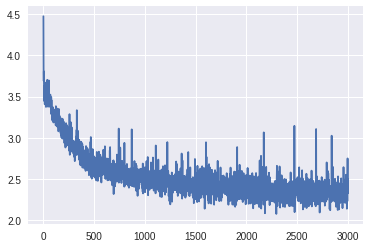

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [20]:
!uptime

 16:01:56 up  2:59,  0 users,  load average: 1.00, 1.00, 1.00


In [21]:
who

Path	 RNN	 USE_GPU	 Variable	 all_characters	 all_losses	 char_tensor	 chunk_len	 criterion	 
dataset_path	 decoder	 decoder_optimizer	 e	 epoch	 evaluate	 file	 file_len	 fn	 
hidden_size	 loss	 loss_avg	 lr	 math	 n_characters	 n_epochs	 n_layers	 nn	 
os	 plot_every	 plt	 print_every	 print_memsize	 psutil	 random	 random_chunk	 random_training_set	 
re	 start	 string	 ticker	 time	 time_since	 tmp_path	 to_gpu	 torch	 
tqdm	 train	 


# Ocena w różnych "temperaturach"

W powyższej funkcji `evaluate`, za każdym razem, gdy dokonywana jest prognoza, wyjścia są dzielone przez przekazany argument "temperature". Używanie większej liczby sprawia, że wszystkie akcje są bardziej jednakowo prawdopodobne, a tym samym dają nam "bardziej losowe" ("more random") wyniki. Używanie mniejszej wartości (mniejszej niż 1) sprawia, że wysokie prawdopodobieństwa przyczyniają się bardziej. Gdy ustawiamy temperaturę na zero, wybieramy tylko najbardziej prawdopodobne wyjścia.

Możemy to zobaczyć poprzez dostosowanie argumentu `temperature`.


In [22]:
print(evaluate('Th', 200, temperature=0.8))

Th szłune i zuła kradzić, Wapówon,
Coby, pażyli po od w sierząża w poczy zabuuczyć na ziatkie bania!

Ta zgrzebiwą znałko, z błowoszki munią wiajsze tażwiał cz kofakienie;

Tadzy.

Tuża szysta grzest st


[link text](https://)Lower temperatures are less varied, choosing only the more probable outputs:

In [23]:
print(evaluate('Th', 200, temperature=0.2))

Th się się się pod usta się szarzy spanie pawie się się stawie w poszycz pod poszczyn w w poszyć się pod poszanie w się się w zabawnie w się się pod się w do pod się w się się się pod wielnie,
I się z s


Higher temperatures more varied, choosing less probable outputs:

In [24]:
print(evaluate('Th', 200, temperature=1.4))

Thażew glują
Obająge wepy gropa nachwieg w oć oka- roy
trzątam Abia.
Néj na w nieźszcza
Bostaśli,
Nugą ę s:-- uciarwadzi tacóna bogu!
Nnam larbąryny możodanać spłostąć
Téczniéj mowonąć;
Agazaz pokał mow


# Ćwiczenia

* Trenuj z własnym zestawem danych, np.
     * Tekst od innego autora
     * Posty na blogu
     * Kod
* Zwiększ liczbę warstw i rozmiar sieci, aby uzyskać lepsze wyniki

**Następnie**: [Generowanie nazw z warunkowym poziomem RNN na poziomie znaku](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)

# Zapisywanie modelu

In [0]:
ALLCHARS, MODEL = ['all_characters', 'model']

fn_pan_tadeusz = {ALLCHARS: 'all_characters.pan_tadeusz.p', MODEL: 'pan_tadeusz.h400.l3.3000.gpu.torch'}

fn_dict = fn_pan_tadeusz

In [0]:
# save all_characters
import pickle

pickle.dump(all_characters, open(tmp_path / fn_dict[ALLCHARS], 'wb'))

In [0]:
# all_characters = pickle.load( open( tmp_path / fn_dict[ALLCHARS], 'rb' ) )
# n_characters = len(all_characters)

In [28]:
decoder.state_dict

<bound method Module.state_dict of RNN(
  (encoder): Embedding(89, 300)
  (gru): GRU(300, 300, num_layers=4)
  (decoder): Linear(in_features=300, out_features=89)
)>

In [29]:
# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
 # decoder = torch.load(model_path)

In [31]:
model_path

PosixPath('/content/data/rnn_generator/tmp/pan_tadeusz.h400.l3.3000.gpu.torch')

In [32]:
ls -lah /content/data/rnn_generator/tmp/

total 8.5M
drwxr-xr-x 2 root root 4.0K May  8 16:02 ./
drwxr-xr-x 3 root root 4.0K May  8 13:19 ../
-rw-r--r-- 1 root root  743 May  8 16:02 all_characters.pan_tadeusz.p
-rw-r--r-- 1 root root 8.5M May  8 16:02 pan_tadeusz.h400.l3.3000.gpu.torch
